In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-disorder/train.csv
/kaggle/input/dataset-disorder/test.csv


In [2]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)



DATA SHAPE: (22083, 45)

DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Id                                        22083 non-null  object 
 1   Patient Age                                       20656 non-null  float64
 2   Genes in mother's side                            22083 non-null  object 
 3   Inherited from father                             21777 non-null  object 
 4   Maternal gene                                     19273 non-null  object 
 5   Paternal gene                                     22083 non-null  object 
 6   Blood cell count (mcL)                            22083 non-null  float64
 7   Patient First Name                                22083 non-null  object 
 8   Family Name                                       12392 non-

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


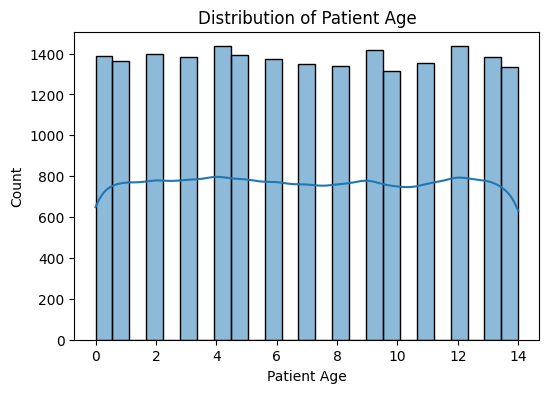

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


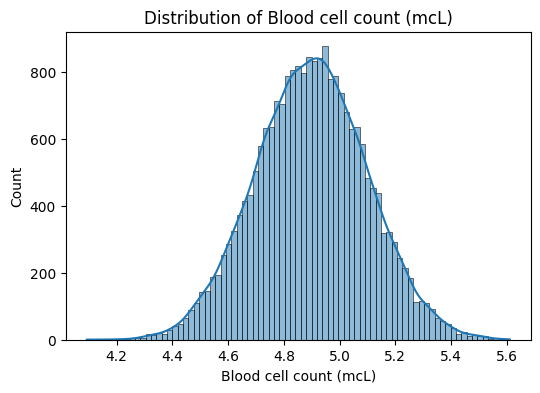

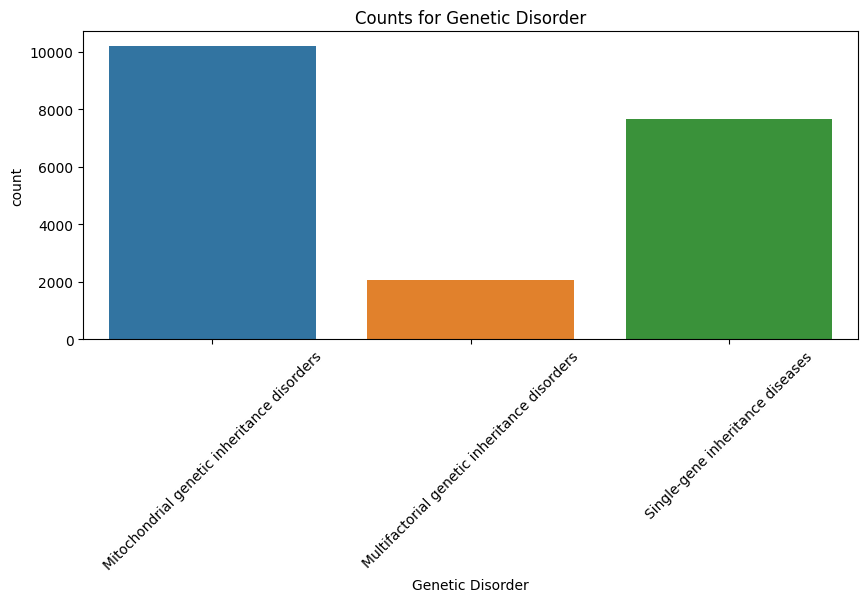

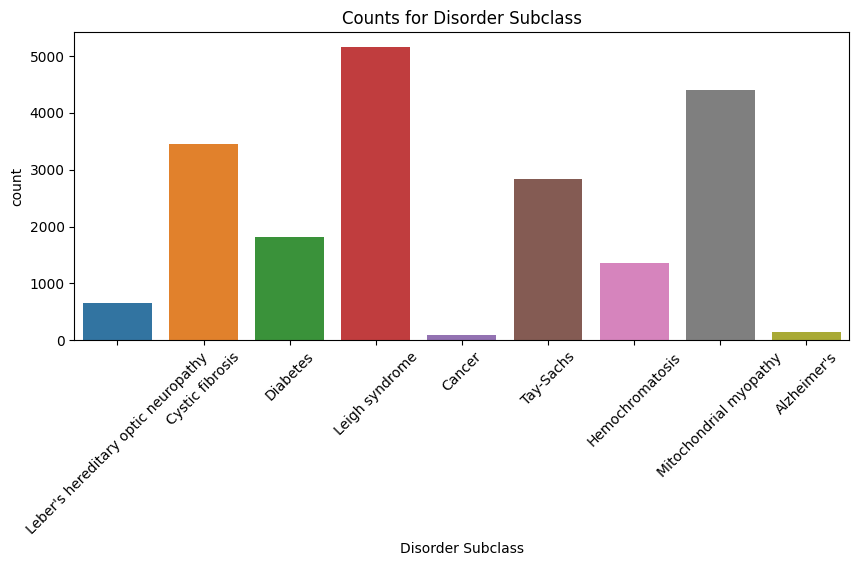

In [3]:
# ===============================
# 2. LOAD DATA & EDA
# ===============================
# Load training data
train_file = r'/kaggle/input/dataset-disorder/train.csv'
data = pd.read_csv(train_file)

# Show basic info
print("DATA SHAPE:", data.shape)
print("\nDATA INFO:")
print(data.info())
print("\nSUMMARY STATISTICS:")
print(data.describe())

# Check missing values
print("\nMISSING VALUES:")
print(data.isnull().sum())

# Plot distributions for a few numerical columns (example)
num_plot_cols = ["Patient Age", "Blood cell count (mcL)" ]
for col in num_plot_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Plot counts for targets (if not too many unique values)
plt.figure(figsize=(10,4))
sns.countplot(x='Genetic Disorder', data=data)
plt.title("Counts for Genetic Disorder")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x='Disorder Subclass', data=data)
plt.title("Counts for Disorder Subclass")
plt.xticks(rotation=45)
plt.show()


In [4]:

# ===============================
# 3. DEFINE GLOBAL VARIABLES
# ===============================
# (These are the columns we will process.)
num_cols = ["Patient Age", "Father's age", "Mother's age", "Blood cell count (mcL)",
            "White Blood cell count (thousand per microliter)", "Test 1", "Test 2",
            "Test 3", "Test 4", "Test 5", "Symptom 1", "Symptom 2", "Symptom 3",
            "Symptom 4", "Symptom 5", "No. of previous abortion"]

cat_cols = ["Gender", "Birth asphyxia", "Parental consent", "Follow-up",
            "Place of birth", "Inherited from father",
            "Maternal gene", "Autopsy shows birth defect (if applicable)",
            "Folic acid details (peri-conceptional)", "H/O serious maternal illness",
            "H/O radiation exposure (x-ray)", "H/O substance abuse",
            "Assisted conception IVF/ART", "History of anomalies in previous pregnancies",
            "Birth defects", "Blood test result", "Genes in mother's side",
            "Respiratory Rate (breaths/min)", "Heart Rate (rates/min", "Location of Institute", "Status", "Paternal gene"]



In [5]:
# ===============================
# 4. PREPROCESSING & TRANSFORMATION PIPELINE
# ===============================
# We define two functions: one to "fit" our transformers on training data, and one to apply them later.

def fit_transformers(X):
    """Fit imputers, encoders, scaler, and feature engineering tools on training DataFrame X.
       Assumes X is a DataFrame with at least num_cols and cat_cols.
    """
    X = X.copy()
    # Impute numerical columns using median
    num_imputer = SimpleImputer(strategy='median')
    X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols, index=X.index)
    
    # Impute categorical columns using mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_cat = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)
    
    # Fit label encoders for categorical columns
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X_cat[col] = le.fit_transform(X_cat[col])
        label_encoders[col] = le

    # Combine numeric and categorical parts
    X_processed = pd.concat([X_num, X_cat], axis=1)
    
    # Outlier removal on numerical features using IQR:
    Q1 = X_processed[num_cols].quantile(0.25)
    Q3 = X_processed[num_cols].quantile(0.75)
    IQR = Q3 - Q1
    X_processed[num_cols] = X_processed[num_cols].mask((X_processed[num_cols] < (Q1 - 1.5*IQR)) |
                                                      (X_processed[num_cols] > (Q3 + 1.5*IQR)))
    # Re-impute any introduced NaNs
    X_processed[num_cols] = pd.DataFrame(num_imputer.transform(X_processed[num_cols]), 
                                          columns=num_cols, index=X.index)
    
    # Feature Engineering:
    # (a) Binned Age: Create a new feature from Patient Age
    age_bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    X_processed['Age_Binned'] = age_bins.fit_transform(X_processed[['Patient Age']])
    # (b) Interaction term: Blood cell count * White blood cell count
    X_processed['Blood_Cell_Interaction'] = (X_processed['Blood cell count (mcL)'] * 
                                               X_processed['White Blood cell count (thousand per microliter)'])
    
    # Scale all numeric features (including engineered ones)
    scaler = StandardScaler()
    numeric_features = X_processed.select_dtypes(include=[np.number]).columns
    X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])
    
    # Return the fitted transformers and the transformed training data
    return X_processed, num_imputer, cat_imputer, label_encoders, scaler, age_bins

def transform_data(X, num_imputer, cat_imputer, label_encoders, scaler, age_bins):
    """Transform new DataFrame X using previously fitted transformers."""
    X = X.copy()
    X_num = pd.DataFrame(num_imputer.transform(X[num_cols]), columns=num_cols, index=X.index)
    X_cat = pd.DataFrame(cat_imputer.transform(X[cat_cols]), columns=cat_cols, index=X.index)
    for col in cat_cols:
        le = label_encoders[col]
        X_cat[col] = le.transform(X_cat[col])
    X_processed = pd.concat([X_num, X_cat], axis=1)
    Q1 = X_processed[num_cols].quantile(0.25)
    Q3 = X_processed[num_cols].quantile(0.75)
    IQR = Q3 - Q1
    X_processed[num_cols] = X_processed[num_cols].mask((X_processed[num_cols] < (Q1 - 1.5*IQR)) |
                                                      (X_processed[num_cols] > (Q3 + 1.5*IQR)))
    X_processed[num_cols] = pd.DataFrame(num_imputer.transform(X_processed[num_cols]), 
                                          columns=num_cols, index=X.index)
    X_processed['Age_Binned'] = age_bins.transform(X_processed[['Patient Age']])
    X_processed['Blood_Cell_Interaction'] = (X_processed['Blood cell count (mcL)'] * 
                                               X_processed['White Blood cell count (thousand per microliter)'])
    numeric_features = X_processed.select_dtypes(include=[np.number]).columns
    X_processed[numeric_features] = scaler.transform(X_processed[numeric_features])
    return X_processed



In [6]:
# ===============================
# 5. PREPARE TRAINING DATA (Stratified on Combined Target)
# ===============================
# Drop rows where targets are missing.
data_clean = data.dropna(subset=["Genetic Disorder", "Disorder Subclass"]).copy()

# Separate features and targets.
# We will predict two targets: "Genetic Disorder" and "Disorder Subclass"
X_raw = data_clean.drop(columns=["Genetic Disorder", "Disorder Subclass"])
y_genetic = data_clean["Genetic Disorder"].copy()
y_subclass = data_clean["Disorder Subclass"].copy()

# Fit our transformation pipeline on the training data
X_transformed, num_imputer, cat_imputer, label_encoders, scaler, age_bins = fit_transformers(X_raw)

# Label-encode the targets (separately)
le_genetic = LabelEncoder()
y_genetic_enc = le_genetic.fit_transform(y_genetic)
le_subclass = LabelEncoder()
y_subclass_enc = le_subclass.fit_transform(y_subclass)

print("\nUnique classes in Genetic Disorder:", le_genetic.classes_)
print("Unique classes in Disorder Subclass:", le_subclass.classes_)

# Create a combined stratification variable to ensure both targets are uniformly split.
y_strat = np.array([f"{g}_{s}" for g, s in zip(y_genetic_enc, y_subclass_enc)])

# Use stratified split based on the combined target variable.
indices = data_clean.index
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y_strat)

X_train = X_transformed.loc[train_idx]
X_test  = X_transformed.loc[test_idx]

# Convert target arrays to pandas Series with the same index for easier selection.
y_genetic_series = pd.Series(y_genetic_enc, index=data_clean.index)
y_subclass_series = pd.Series(y_subclass_enc, index=data_clean.index)

y_genetic_train = y_genetic_series.loc[train_idx].values
y_genetic_test  = y_genetic_series.loc[test_idx].values
y_subclass_train = y_subclass_series.loc[train_idx].values
y_subclass_test  = y_subclass_series.loc[test_idx].values

# Optionally, print shapes to confirm:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_genetic_train shape:", y_genetic_train.shape)
print("y_subclass_train shape:", y_subclass_train.shape)



Unique classes in Genetic Disorder: ['Mitochondrial genetic inheritance disorders'
 'Multifactorial genetic inheritance disorders'
 'Single-gene inheritance diseases']
Unique classes in Disorder Subclass: ["Alzheimer's" 'Cancer' 'Cystic fibrosis' 'Diabetes' 'Hemochromatosis'
 "Leber's hereditary optic neuropathy" 'Leigh syndrome'
 'Mitochondrial myopathy' 'Tay-Sachs']
X_train shape: (14437, 40)
X_test shape: (3610, 40)
y_genetic_train shape: (14437,)
y_subclass_train shape: (14437,)


In [7]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Define the base models
base_models = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Define the meta learner
meta_learner = LogisticRegression(max_iter=1000)

# Build the stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=3 # 5-fold cross-validation for stacking
)

# Example usage:
stacked_model.fit(X_train, y_genetic_train)
y_pred = stacked_model.predict(X_test)
print("Stacked Model Accuracy for genetic:", accuracy_score(y_genetic_test, y_pred))



Stacked Model Accuracy for genetic: 0.5670360110803324


In [8]:
# ===============================
# 6. BUILD & TRAIN NEURAL NETWORK MODELS (TENSORFLOW)
# ===============================
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.4))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0033213),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build model for Genetic Disorder prediction
num_classes_genetic = len(np.unique(y_genetic_train))
model_genetic = build_model(X_train.shape[1], num_classes_genetic)
# Build model for Disorder Subclass prediction
num_classes_subclass = len(np.unique(y_subclass_train))
model_subclass = build_model(X_train.shape[1], num_classes_subclass)

# Callbacks for training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Train Genetic Disorder model
print("\nTraining Genetic Disorder Model...")
history_genetic = model_genetic.fit(X_train, y_genetic_train,
                                    epochs=50,
                                    batch_size=32,
                                    validation_data=(X_test, y_genetic_test),
                                    callbacks=[early_stop, reduce_lr],
                                    verbose=1)

# Train Disorder Subclass model
print("\nTraining Disorder Subclass Model...")
history_subclass = model_subclass.fit(X_train, y_subclass_train,
                                      epochs=50,
                                      batch_size=32,
                                      validation_data=(X_test, y_subclass_test),
                                      callbacks=[early_stop, reduce_lr],
                                      verbose=1)

# Evaluate and report performance
print("\nEvaluating Genetic Disorder Model on Test Data:")
loss_gen, acc_gen = model_genetic.evaluate(X_test, y_genetic_test, verbose=0)
print(f"Genetic Disorder Model Accuracy: {acc_gen:.4f}")
y_pred_gen = np.argmax(model_genetic.predict(X_test), axis=1)
print("\nClassification Report for Genetic Disorder:")
print(classification_report(y_genetic_test, y_pred_gen, target_names=[str(c) for c in le_genetic.classes_]))

print("\nEvaluating Disorder Subclass Model on Test Data:")
loss_sub, acc_sub = model_subclass.evaluate(X_test, y_subclass_test, verbose=0)
print(f"Disorder Subclass Model Accuracy: {acc_sub:.4f}")
y_pred_sub = np.argmax(model_subclass.predict(X_test), axis=1)
print("\nClassification Report for Disorder Subclass:")
print(classification_report(y_subclass_test, y_pred_sub, target_names=[str(c) for c in le_subclass.classes_]))




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Genetic Disorder Model...
Epoch 1/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4898 - loss: 0.9566 - val_accuracy: 0.5440 - val_loss: 0.8758 - learning_rate: 0.0033
Epoch 2/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5295 - loss: 0.8890 - val_accuracy: 0.5704 - val_loss: 0.8429 - learning_rate: 0.0033
Epoch 3/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5607 - loss: 0.8498 - val_accuracy: 0.5781 - val_loss: 0.8305 - learning_rate: 0.0033
Epoch 4/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5707 - loss: 0.8428 - val_accuracy: 0.5889 - val_loss: 0.8121 - learning_rate: 0.0033
Epoch 5/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5861 - loss: 0.8293 - val_accuracy: 0.5931 - val_loss: 0.8142 - learning_rate: 0.0033
Epoch 6/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5921 - loss: 0.8244 - val_accuracy: 0.5848 - val_loss: 0.8133 - learning_rate: 0.0033
Epoch 7/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
